In [39]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import pickle
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from scipy import signal
import nrrd
from PIL import Image

In [40]:
fname_epi = "/work/jprieto/data/remote/EGower/hinashah/Analysis_Set_01132022/trachoma_normals_healthy_sev123_epi_patches_test.csv"

df_epi = pd.read_csv(fname_epi)
df_epi.drop(df_epi[df_epi['patch_class'].isin(['Probable Epilation', 'Probable TT'])].index, inplace = True)
df_epi = df_epi.reset_index()
df_epi = df_epi.replace({'Healthy': 0, 'TT': 1, 'Epilation': 2})

with open("/work/jprieto/data/remote/EGower/jprieto/test_output/patch_training_resnet_17012022.pickle", 'rb') as f:
    results_epi = pickle.load(f)

pred_np, feat_np = results_epi
    
pred_np = np.array(pred_np)
feat_np = np.array(feat_np)

print(pred_np.shape)
print(feat_np.shape)

df_epi["pred"] = np.argmax(pred_np, axis=1)
# results_epi.drop(results_epi[results_epi['patch_class'].isin(['Probable Epilation', 'Probable TT'])].index, inplace = True)
# results_epi = results_epi.reset_index()
# results_epi = results_epi.replace({'Healthy': 0, 'TT': 1, 'Epilation': 2})

(7096, 3)
(7096, 512)


In [41]:
csv_true_column = "patch_class"
csv_prediction_column = "pred"
y_true_arr = [] 
y_pred_arr = []
for idx, row in df_epi.iterrows():
  y_true_arr.append(row[csv_true_column])
  y_pred_arr.append(row[csv_prediction_column])


In [42]:
cnf_matrix = confusion_matrix(y_true_arr, y_pred_arr)
print(cnf_matrix)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
print(cnf_matrix_norm)
print(classification_report(y_true_arr, y_pred_arr))

[[1702   28   42]
 [ 178 4049  126]
 [  72   60  839]]
[[0.96049661 0.01580135 0.02370203]
 [0.04089134 0.93016311 0.02894555]
 [0.07415036 0.06179197 0.86405767]]
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1772
           1       0.98      0.93      0.95      4353
           2       0.83      0.86      0.85       971

    accuracy                           0.93      7096
   macro avg       0.89      0.92      0.91      7096
weighted avg       0.93      0.93      0.93      7096



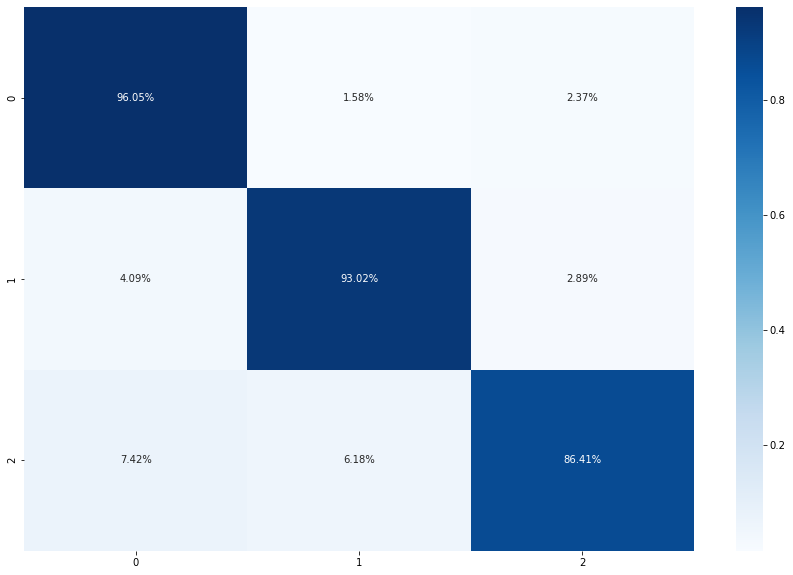

In [43]:
plt.figure(figsize=[15,10])
sns.heatmap(cnf_matrix_norm, annot=True, fmt='.2%', cmap='Blues')
plt.show()

In [36]:
pca_epi = PCA(n_components=2)
pca_epi_fit = pca_epi.fit_transform(feat_np)
df_epi["pca_0"] = pca_epi_fit[:,0]
df_epi["pca_1"] = pca_epi_fit[:,1]

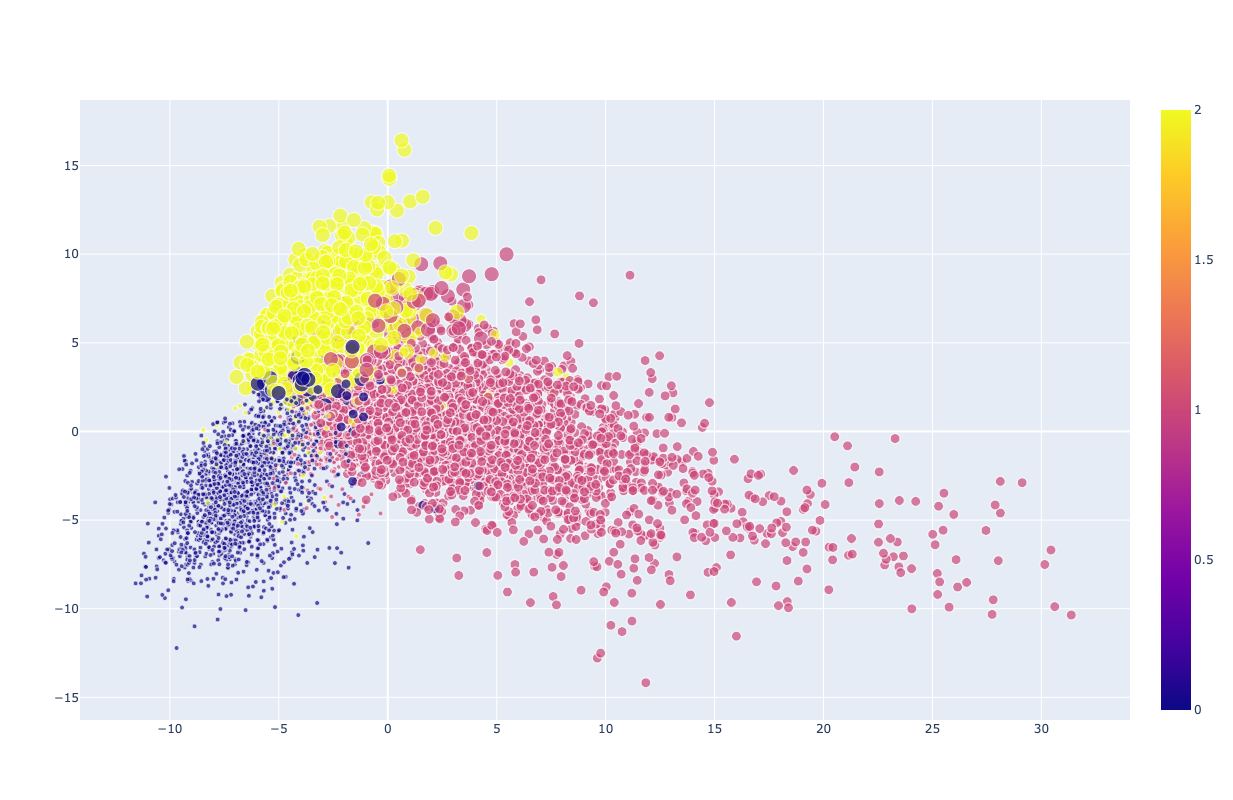

In [37]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_epi["pca_0"], y=df_epi["pca_1"], mode='markers', text=df_epi["pred"], marker=dict(color=df_epi["patch_class"], size=(df_epi["pred"]+1)*5, showscale=True)))
fig.update_layout(
    autosize=False,
    width=1200,
    height=800
)
fig

In [38]:
df_miss_classified = df_epi.query("pred != patch_class").reset_index(drop=True)
df_classified = df_epi.query("pred == patch_class").reset_index(drop=True)
df_tt = df_epi.query("patch_class > 0 and pred == 0").reset_index(drop=True)

fig = go.FigureWidget(make_subplots(rows=1, cols=2, column_widths=[0.6, 0.4], specs=[[{}, {}]]))

fig.add_trace(go.Scatter(x=df_miss_classified["pca_0"], y=df_miss_classified["pca_1"], mode='markers', 
                         text=["class: {}, pred: {}".format(c, p) for c, p in zip(df_miss_classified["patch_class"], df_miss_classified["pred"])], 
                         marker=dict(color=df_miss_classified["patch_class"], size=(df_miss_classified["pred"]+1)*5)), row=1, col=1)
fig.add_trace(go.Image(), row=1, col=2)

fig.update_layout(
    autosize=False,
    width=1500,
    height=600
)

def update_img(trace, points, selector):
    if points.trace_name == 'trace 0' and len(points.point_inds) > 0:
        
        print('update_img', points)
        idx = points.point_inds[0] 
        img_path = os.path.join("/work/jprieto/data/remote/EGower/", df_miss_classified.loc[idx]["image"])
        pic = Image.open(img_path)
        img_np = np.array(pic.getdata()).reshape(pic.size[0], pic.size[1], 3)
        
        with fig.batch_update():   
            print(img_np.shape)
            fig.data[1]['z'] = img_np
    
fig.data[0].on_click(update_img)

fig

FigureWidget({
    'data': [{'marker': {'color': array([1, 1, 1, ..., 0, 0, 0]),
                         'siz…

In [44]:
csv_path_stacks = "/work/jprieto/data/remote/EGower/jprieto/hinashah/Analysis_Set_01132022/trachoma_normals_healthy_sev123_epi_stack_16_768_test.csv"
output_dir = "/work/jprieto/data/remote/EGower/jprieto/test_output/"
results_stacks_path = os.path.join(output_dir, 'trachoma_normals_healthy_sev123_epi_stack_16_768_test_17012022.pickle')


In [45]:
df_stacks = pd.read_csv(csv_path_stacks)
df_stacks['class'] = (df_stacks['class'] >= 1).astype(int)
with open(results_stacks_path, 'rb') as f:
    results_stacks = pickle.load(f) #x, x_a, x_v, x_s, x_v_p
    

pred_np, x_a_np, x_v_np, x_s_np, x_v_p_np = results_stacks
pred_np = np.array(pred_np)
x_a_np = np.array(x_a_np)
x_v_np = np.array(x_v_np)
x_s_np = np.array(x_s_np)
x_v_p_np = np.array(x_v_p_np)
print(len(results_stacks), len(df_stacks))

5 1608


In [46]:
df_stacks["pred"] = np.argmax(pred_np, axis=1)

In [47]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(x_a_np)
df_stacks["pca_0"] = X_pca[:,0]
df_stacks["pca_1"] = X_pca[:,1]

[[ 380   57]
 [  92 1079]]
[[0.86956522 0.13043478]
 [0.07856533 0.92143467]]
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       437
           1       0.95      0.92      0.94      1171

    accuracy                           0.91      1608
   macro avg       0.88      0.90      0.89      1608
weighted avg       0.91      0.91      0.91      1608



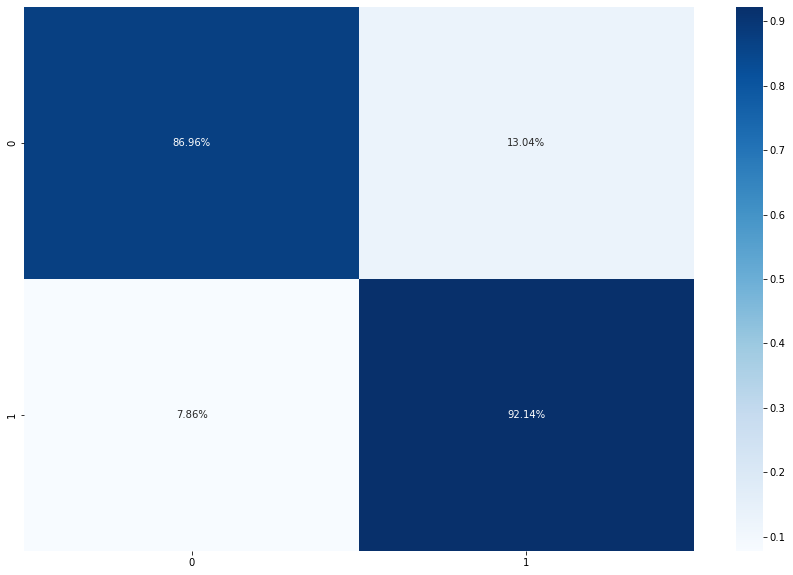

In [49]:
y_true_arr_stacks = [] 
y_pred_arr_stacks = []
for idx, row in df_stacks.iterrows():
  y_true_arr_stacks.append(row["class"])
  y_pred_arr_stacks.append(row["pred"])
    
cnf_matrix_stacks = confusion_matrix(y_true_arr_stacks, y_pred_arr_stacks)
print(cnf_matrix_stacks)
cnf_matrix_norm_stacks = cnf_matrix_stacks.astype('float') / cnf_matrix_stacks.sum(axis=1)[:, np.newaxis]
print(cnf_matrix_norm_stacks)
print(classification_report(y_true_arr_stacks, y_pred_arr_stacks))

plt.figure(figsize=[15,10])
sns.heatmap(cnf_matrix_norm_stacks, annot=True, fmt='.2%', cmap='Blues')
plt.show()

In [19]:
df_stacks

,img,orig,class,severity_class,pred,pca_0,pca_1
0,/work/jprieto/data/remote/EGower/jprieto/trach...,/work/jprieto/data/remote/EGower/jprieto/eyes_...,1,3,1,-0.640343,-0.389170
1,/work/jprieto/data/remote/EGower/jprieto/trach...,/work/jprieto/data/remote/EGower/jprieto/eyes_...,1,3,1,-2.867932,0.137310
2,/work/jprieto/data/remote/EGower/jprieto/trach...,/work/jprieto/data/remote/EGower/jprieto/eyes_...,1,3,1,-3.279604,0.747792
3,/work/jprieto/data/remote/EGower/jprieto/trach...,/work/jprieto/data/remote/EGower/jprieto/eyes_...,1,3,1,-2.594342,0.001020
4,/work/jprieto/data/remote/EGower/jprieto/trach...,/work/jprieto/data/remote/EGower/jprieto/eyes_...,1,3,1,-3.823278,0.871046
...,...,...,...,...,...,...,...
398,/work/jprieto/data/remote/EGower/jprieto/trach...,/work/jprieto/data/remote/EGower/jprieto/eyes_...,1,1,1,0.420890,-0.278760
399,/work/jprieto/data/remote/EGower/jprieto/trach...,/work/jprieto/data/remote/EGower/jprieto/eyes_...,1,1,1,-1.330279,-0.480179
400,/work/jprieto/data/remote/EGower/jprieto/trach...,/work/jprieto/data/remote/EGower/jprieto/eyes_...,1,1,1,0.985677,-0.072837
401,/work/jprieto/data/remote/EGower/jprieto/trach...,/work/jprieto/data/remote/EGower/jprieto/eyes_...,1,1,0,2.136998,-0.464287


In [57]:
fig = go.FigureWidget(make_subplots(rows=2, cols=2, column_widths=[0.7, 0.3], specs=[[{'colspan': 2}, {}],[{},{}]]))

fig.add_trace(go.Scatter(x=df_stacks["pca_0"], y=df_stacks["pca_1"], mode='markers', showlegend=False, 
                         text=["class: {}, pred: {}".format(c, p) for c, p in zip(df_stacks["class"], df_stacks["pred"])],
                         marker=dict(
                             color=df_stacks["class"], size=(df_stacks["pred"] + 1)*5, colorscale='sunset', showscale=True, opacity=1, line=dict(color='red', width=1))
                        ), row=1, col=1)
fig.add_trace(go.Scatter(mode='markers', showlegend=False, marker=dict(showscale=True, size=10, cmin=np.min(x_v_p_np), cmax=np.max(x_v_p_np), colorscale='sunset', line=dict(color='red', width=1))), row=2, col=1)
fig.add_trace(go.Scatter(mode='markers', marker=dict(color='LightSkyBlue', size=10), showlegend=False), row=2, col=1)
fig.add_trace(go.Image(), row=2, col=2)

fig.add_trace(go.Scatter(mode='markers', showlegend=False, marker=dict(showscale=False, size=10, cmin=np.min(x_v_p_np), cmax=np.max(x_v_p_np), colorscale='sunset', line=dict(color='magenta', width=2))), row=1, col=1)
fig.add_trace(go.Scatter(mode='markers', showlegend=False, marker=dict(showscale=False, size=10, cmin=np.min(x_v_p_np), cmax=np.max(x_v_p_np), colorscale='sunset', line=dict(color='magenta', width=2))), row=2, col=1)

fig.data[0].marker.showscale = True
fig.data[0].marker.colorbar.y = 0.8
fig.data[0].marker.colorbar.len = 0.5

fig.data[1].marker.showscale = True
fig.data[1].marker.colorbar.y = .2
fig.data[1].marker.colorbar.len = 0.5

fig.update_layout(
    autosize=False,
    width=1200,
    height=800
)

current_idx = {"idx": 0, "idx_f": 0, "img_np": []}

def update_study(trace, points, selector):
    if points.trace_name == 'trace 0' and len(points.point_inds) > 0:
        print("update_study", points)
        idx = points.point_inds[0]  
        x_feat_idx = np.array(x_v_np[idx]).reshape(-1, 256)
        x_feat_idx_pca = pca.transform(x_feat_idx)
        print(x_feat_idx_pca.shape)
#         scores_idx = np.array(scores[idx]).reshape(-1)
#         weights_idx = np.array(weights[idx]).reshape(-1)
        print(x_v_p_np.shape)
        df_idx = pd.DataFrame({
            "pca_0": x_feat_idx_pca[:,0],
            "pca_1": x_feat_idx_pca[:,1],
            "pred": np.array(np.argmax(x_v_p_np[idx], axis=1)).reshape(-1), 
            "score": np.array(x_s_np[idx]).reshape(-1)
#             ,
#             "scores": scores_idx,
#             "weights": weights_idx
            })

        with fig.batch_update():
            fig.data[1]['x'] = df_idx["pca_0"]
            fig.data[1]['y'] = df_idx["pca_1"]
            fig.data[1].marker.color = df_idx['pred']
            fig.data[1].text = ['s: {:f}, p: {:f}'.format(s, p) for s, p in zip(df_idx['score'], df_idx['pred'])]
#             fig.data[1].marker.cmin = np.max()
#             fig.data[1].marker.cmax = 1
            
            fig.data[2]['x'] = [df_stacks.loc[idx]["pca_0"]]
            fig.data[2]['y'] = [df_stacks.loc[idx]["pca_1"]]
              
            fig.data[4]['x'] = [df_stacks.loc[idx]["pca_0"]]
            fig.data[4]['y'] = [df_stacks.loc[idx]["pca_1"]]
            fig.data[4].marker.color = df_stacks.loc[idx]["class"]
            
            fig.update_layout(title=df_stacks.loc[idx]["img"])

            current_idx["idx"] = idx
            current_idx["img_np"] = nrrd.read(os.path.join("/work/jprieto/data/remote/EGower/", df_stacks.loc[idx]["img"]), index_order='C')[0]
            current_idx["df_idx"] = df_idx
            
            print(os.path.basename(df_stacks.loc[idx]["img"]))
            
fig.data[0].on_click(update_study)

def update_img(trace, points, selector):
    if points.trace_name == 'trace 1' and len(points.point_inds) > 0:
        print('update_img', points)
        idx_f = points.point_inds[0] 
        current_idx["idx_f"] = idx_f
        
        with fig.batch_update():
#             fig.data[3]['z'] = current_idx["img_np"][idx_f]
            print(idx_f)
#             fig.data[3]['z'] = np.flip(current_idx["img_np"][idx_f], axis=1)
            fig.data[3]['z'] = current_idx["img_np"][idx_f]
        
            fig.data[5]['x'] = [current_idx["df_idx"].loc[idx_f]["pca_0"]]
            fig.data[5]['y'] = [current_idx["df_idx"].loc[idx_f]["pca_1"]]
            fig.data[5].marker.color = current_idx["df_idx"].loc[idx_f]["pred"]
    
fig.data[1].on_click(update_img)

fig

FigureWidget({
    'data': [{'marker': {'color': array([1, 0, 1, ..., 0, 0, 0]),
                         'col…

In [50]:
csv_path_stacks_0 = "/work/jprieto/data/remote/EGower/jprieto/trachoma_normals_healthy_sev123_05182021_stack_16_544_10082021_test.csv"
output_dir_0 = "/work/jprieto/data/remote/EGower/jprieto/test_output/"
results_stacks_path_0 = os.path.join(output_dir_0, 'trachoma_normals_healthy_sev123_05182021_stack_16_544_10082021_test_17012022.pickle')


In [51]:
df_stacks_0 = pd.read_csv(csv_path_stacks_0)
df_stacks_0['class'] = (df_stacks_0['class'] >= 1).astype(int)
with open(results_stacks_path_0, 'rb') as f:
    results_stacks_0 = pickle.load(f) #x, x_a, x_v, x_s, x_v_p
    

pred_np_0, x_a_np_0, x_v_np_0, x_s_np_0, x_v_p_np_0 = results_stacks_0
pred_np_0 = np.array(pred_np_0)
x_a_np_0 = np.array(x_a_np_0)
x_v_np_0 = np.array(x_v_np_0)
x_s_np_0 = np.array(x_s_np_0)
x_v_p_np_0 = np.array(x_v_p_np_0)


In [52]:
df_stacks_0["pred"] = np.argmax(pred_np_0, axis=1)

[[ 88  21]
 [ 14 280]]
[[0.80733945 0.19266055]
 [0.04761905 0.95238095]]
              precision    recall  f1-score   support

           0       0.86      0.81      0.83       109
           1       0.93      0.95      0.94       294

    accuracy                           0.91       403
   macro avg       0.90      0.88      0.89       403
weighted avg       0.91      0.91      0.91       403



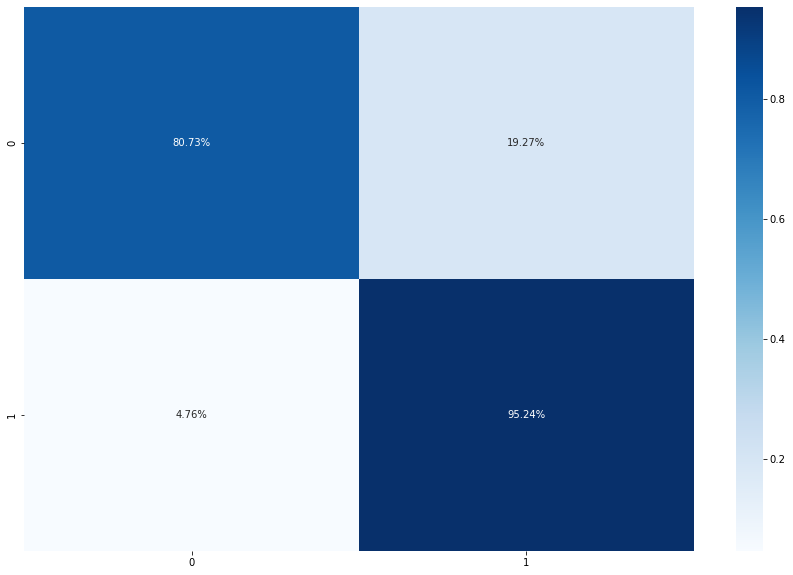

In [53]:
y_true_arr_stacks = [] 
y_pred_arr_stacks = []
for idx, row in df_stacks_0.iterrows():
  y_true_arr_stacks.append(row["class"])
  y_pred_arr_stacks.append(row["pred"])
    
cnf_matrix_stacks = confusion_matrix(y_true_arr_stacks, y_pred_arr_stacks)
print(cnf_matrix_stacks)
cnf_matrix_norm_stacks = cnf_matrix_stacks.astype('float') / cnf_matrix_stacks.sum(axis=1)[:, np.newaxis]
print(cnf_matrix_norm_stacks)
print(classification_report(y_true_arr_stacks, y_pred_arr_stacks))

plt.figure(figsize=[15,10])
sns.heatmap(cnf_matrix_norm_stacks, annot=True, fmt='.2%', cmap='Blues')
plt.show()